# DECISION TREE FOR FOOD 101
# EXTRACTING FEATURES WITH THE THESE METHODS TO BUILD THE MODEL:
## 1.  HISTOGRAM OF ORIENTED GRADIENTS;HOG >>>> (Shape Features)
## 2.  COLOR HISTOGRAM EXTRACTION >>>>> (Color-based Features)
## 3.  Local Binary Patterns (LBP): Describe the local texture patterns, specifcally good for texture-based classification and works well with Decision Trees.
##  4. Gabor Filters: Gabor filters detect edges and textures, which may help in food classification. They Capture frequency and orientation information
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# FEATURE SELECTION WITH THESE TECHNIQUES
## SELECT K BEST AND Recursive Feature Elimination
## Use SelectKBest to remove irrelevant features, then apply RFE on the reduced set.


# Food Image Classification for Nutritional Estimation
# TEST 8 using SCIKIT_LEARN AND EXTRACTING TRADITIONAL IMAGE FEATURES



# IMPORTING LIBRARIES

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from skimage.feature import local_binary_pattern
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


# LOAD FOOD101 TENSORFLOW DATASET & PRINT FIRST 10 FOOD CLASSES

In [2]:
# Load Food-101 dataset
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

class_names = info.features["label"].names[:10]
# Get the first 10 class names

# Print information about the dataset
print("First 10 classes:", class_names)
# Print class names of the first 10 classes for confirmation


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.DROQLH_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.DROQLH_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
First 10 classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


# FUCNTION TO FILTER FOOD101 TO MATCH FIRST 10 CLASS NAMES SELECTED

In [3]:
# Measure training time for runtime performance
start_time = time.time()

# Function to filter dataset to only the first 10 classes

def filter_classes(image, label):
  # paremter image and label for labeling each food image class

    return label < 10
    # Keep only images where label is between 0 and 9 (first 10 classes)

# Apply filter to remove unwanted classes in FOOD 101 dataset
filtered_dataset = dataset.filter(filter_classes)

# Count dataset size to ensure same size across. SUM of all 1s
dataset_size = sum(1 for _ in filtered_dataset)

# print total images in filtered dataset
print(f"Total images in first 10 classes: {dataset_size}")

Total images in first 10 classes: 7500


# DISPLAY ONE  IMAGE PER UNIQUE FOOD CLASS

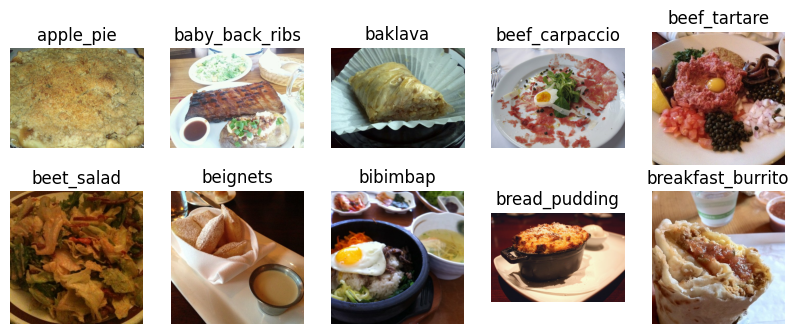

In [4]:
# Dictionary to store one image per class
class_images = {}

# for loop to iterate through filtered 10 classes dataset
for image, label in filtered_dataset:
  # for each image and class label

    label_value = label.numpy()
    # for converting the tensorflow tensor label to python numpy integer
    # integer is need for the indexing in teh dictionary

    # interating through the dictionary storing the first images for each unique food classs label
    if label_value not in class_images:
    # if the integer as the label is not in the dictionary

        class_images[label_value] = image
        # aasign an image from the dataset corresponding uniquely to the dictionary stored food class labels

    if len(class_images) == 10:
    # Stop when we have one image per class coreresponding to each food class
        break

# Plot images
plt.figure(figsize=(10, 10))
# creating a new figure with 10 inches width and height

# iteraing over each key- value pair (class label and an image)
for i, (label, image) in enumerate(sorted(class_images.items())):
    # sorting the items in order and enumerating

    plt.subplot(5, 5, i + 1)
    # subplot in figure for 5 rows and 5 columns

    plt.imshow(image.numpy())
    # displays the image subplot
    # converting the tensorflow tensor image to python numpy integer for matplotlib

    plt.title(class_names[label])
    # sets the title of each plot to the label of each class name

    plt.axis("off")
    # removes axis ticks

plt.show()
# displays complete figure

# DATASET PREPARATION: Split into Train & Validation Sets

In [5]:
# Define train-validation split (80-20)
train_split = 0.8
# 80% for training

train_size = int(train_split * dataset_size)
# the defined split 0.8 multiplied by the dataset size, ensured to return integer and stored in train_size variable

# Split the dataset
# train set
train_ds = filtered_dataset.take(train_size)
# take () method extracts the train_size from the filtered dataset, 80% of filtered dataset

# validation set
val_ds = filtered_dataset.skip(train_size)
# skip () method ignores the train_size from the filtered dataset, remaining 20% of filtered dataset used for validation
# remaining 20% sample from dataset

print(f"Training set size: {train_size}")
print(f"Validation set size: {dataset_size - train_size}")

Training set size: 6000
Validation set size: 1500


# DATASET PREPROCESSING: Resizing image and normalisation

In [6]:
def preprocess(image, label):

    """Preprocess function to resize image and normalize pixel values."""

    image = tf.image.resize(image, (128, 128))  # Resize for consistency
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

# Apply preprocessing and batching
train_ds = train_ds.map(preprocess).batch(32)
val_ds = val_ds.map(preprocess).batch(32)

# Checking Image Shapes

In [7]:
# Check the shape of images
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("First image shape:", images[0].shape)
    print("Image data type:", images.dtype)
    print("First few pixel values:", images[0,0,0:5])

Image batch shape: (32, 128, 128, 3)
First image shape: (128, 128, 3)
Image data type: <dtype: 'float32'>
First few pixel values: tf.Tensor(
[[0.33431372 0.10980392 0.0882353 ]
 [0.3647059  0.13333334 0.10980392]
 [0.31666666 0.12058824 0.1       ]
 [0.24117647 0.09411765 0.08921569]
 [0.19705883 0.11176471 0.12058824]], shape=(5, 3), dtype=float32)


# LOAD DECISION TREE MODEL

In [8]:
# Create and train decision tree
dt_classifier = DecisionTreeClassifier(random_state=42)

print ('decision tree model loaded.')

decision tree model loaded.


# Extract HOG, LBP ,Gabor Filters and Color Histogram Features

In [9]:
def extract_combined_features(dataset):
    features = []
    labels = []

    for batch_images, batch_labels in dataset:
        batch_images = batch_images.numpy()
        batch_labels = batch_labels.numpy()

        for i in range(len(batch_images)):
            img = batch_images[i]

            # ------------------
            # Extract Color Histogram Features
            r_hist = np.histogram(img[:, :, 0], bins=8, range=(0, 1))[0]
            g_hist = np.histogram(img[:, :, 1], bins=8, range=(0, 1))[0]
            b_hist = np.histogram(img[:, :, 2], bins=8, range=(0, 1))[0]
            color_features = np.concatenate([r_hist, g_hist, b_hist])

            # ------------------
            # Extract HOG Features
            gray = np.dot(img, [0.2989, 0.5870, 0.1140])
            hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

            # ------------------
            # Extract LBP Features
            lbp = local_binary_pattern(gray, P=24, R=3, method="uniform")
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 25), range=(0, 24))

            # ------------------
            # Extract Gabor Features
            def extract_gabor_features(image):
                kernels = [cv2.getGaborKernel((21, 21), sigma, theta, 10, 0.5, 0, ktype=cv2.CV_32F)
                        for sigma in (1, 3) for theta in np.arange(0, np.pi, np.pi / 4)]
                filtered_images = [cv2.filter2D(image, cv2.CV_8UC3, k) for k in kernels]
                return np.array([f.mean() for f in filtered_images])  # Mean intensity of filtered images

            gabor_features = extract_gabor_features(gray)

            # ------------------
            # Feature Fusion (Concatenating All Extracted Features)
            combined_features = np.concatenate([color_features, hog_features, lbp_hist, gabor_features])

            features.append(combined_features)
            labels.append(batch_labels[i])


    return np.array(features), np.array(labels)


    # Extract HOG & Color Histogram features
X_train, y_train = extract_combined_features(train_ds)
X_val, y_val = extract_combined_features(val_ds)

print("All features have been extracted.")
print("Combined feature vector size:", X_train.shape[1])

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


All features have been extracted.
Combined feature vector size: 8156


# Select Kbest and RFE - (Recursive Feature Elimination) For Feature Selection

In [10]:
# Step 1: SelectKBest - Remove weak features
selector = SelectKBest(f_classif, k=100)  # Keep top 300 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)

# Step 2: RFE - Recursive Feature Elimination
rfe = RFE(dt_classifier, n_features_to_select=50)  # Keep top 200 features
X_train_final = rfe.fit_transform(X_train_selected, y_train)
X_val_final = rfe.transform(X_val_selected)

print("Combined feature vector size:", X_train_selected.shape[1])

Combined feature vector size: 100


# Hyperparameter Tuning for Decision Trees GridSearch CV


In [11]:
# Decision Tree Hyperparameters
# We'll use GridSearchCV to try different hyperparameters for the Decision Tree

# param_grid = {
    # 'max_depth': [5, 10, 15],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
# }


# Decision Tree Hyperparameters 2 i love you
# To reduce overfitting of models i love you more alfred < 3

param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20, 50],  # Higher values reduce overfitting
    'min_samples_leaf': [5, 10, 20],  # Increase min_samples_leaf
    'ccp_alpha': [0.001, 0.01, 0.1]
}

# Train the Decision Tree

In [12]:
# Train the Decision Tree classifier
grid_search = GridSearchCV(dt_classifier, param_grid, cv=7, scoring='accuracy', verbose=1)
grid_search.fit(X_train_final, y_train)

print("Best parameters found:", grid_search.best_params_)
best_dt = grid_search.best_estimator_

# Calculate training time
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

Fitting 7 folds for each of 81 candidates, totalling 567 fits
Best parameters found: {'ccp_alpha': 0.001, 'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 10}
Training time: 368.65 seconds


# Evaluation and Prediction

In [13]:
# Predictions
# Evaluate on training data
y_train_pred = best_dt.predict(X_train_final)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate on validation data
y_val_pred = best_dt.predict(X_val_final)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print accuracy
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Train Accuracy: 0.2818333333333333
Validation Accuracy: 0.22533333333333333


# Further Evaluation, Predictions and Peformance Calculation.


In [14]:
# Calculate loss (for example, using log_loss)
y_train_prob = best_dt.predict_proba(X_train_final)
y_val_prob = best_dt.predict_proba(X_val_final)
train_loss = log_loss(y_train, y_train_prob)

val_loss = log_loss(y_val, y_val_prob)
print(f"Train loss: {train_loss:.4f}\n")
print(f"Validation loss: {val_loss:.4f}\n")

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Get classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=class_names))

Train loss: 2.0266

Validation loss: 2.2267

Train Accuracy: 0.2818333333333333
Validation Accuracy: 0.22533333333333333

Classification Report:
                   precision    recall  f1-score   support

        apple_pie       0.16      0.16      0.16       152
   baby_back_ribs       0.30      0.25      0.28       135
          baklava       0.19      0.26      0.22       138
   beef_carpaccio       0.18      0.28      0.22       155
     beef_tartare       0.27      0.11      0.15       157
       beet_salad       0.16      0.12      0.13       144
         beignets       0.29      0.22      0.25       170
         bibimbap       0.33      0.48      0.39       166
    bread_pudding       0.18      0.15      0.16       144
breakfast_burrito       0.18      0.19      0.19       139

         accuracy                           0.23      1500
        macro avg       0.22      0.22      0.22      1500
     weighted avg       0.23      0.23      0.22      1500



# Visualize metrics: Confusion matrix

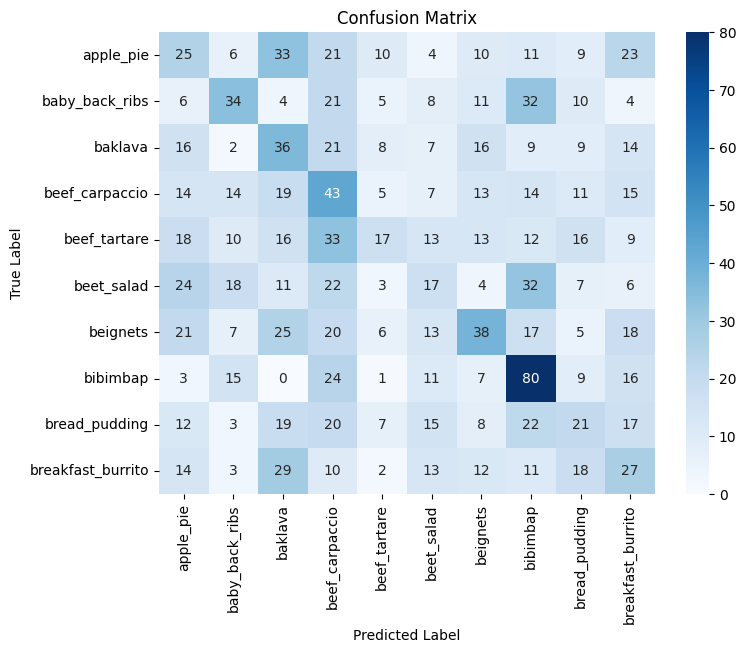

In [15]:
# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# 2. Plot confusion matrix
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Visualize metrics: Accuracy and loss

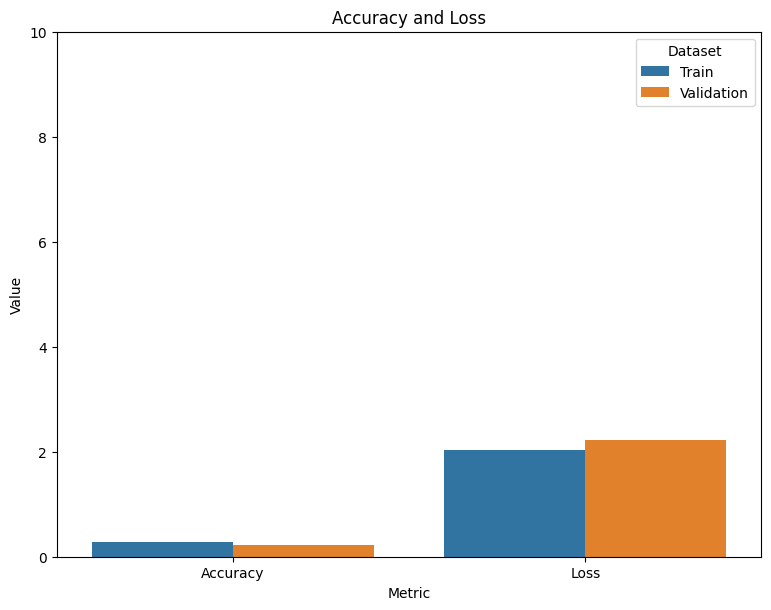

In [16]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Train': [train_accuracy, train_loss],
    'Validation': [val_accuracy, val_loss]
})
metrics_melted = pd.melt(metrics, id_vars=['Metric'], var_name='Dataset', value_name='Value')
sns.barplot(x='Metric', y='Value', hue='Dataset', data=metrics_melted)
plt.title('Accuracy and Loss')

plt.ylim(0,10)
plt.show()

# Visualize metrics: Precision, Recall, f1-score

<Figure size 1000x600 with 0 Axes>

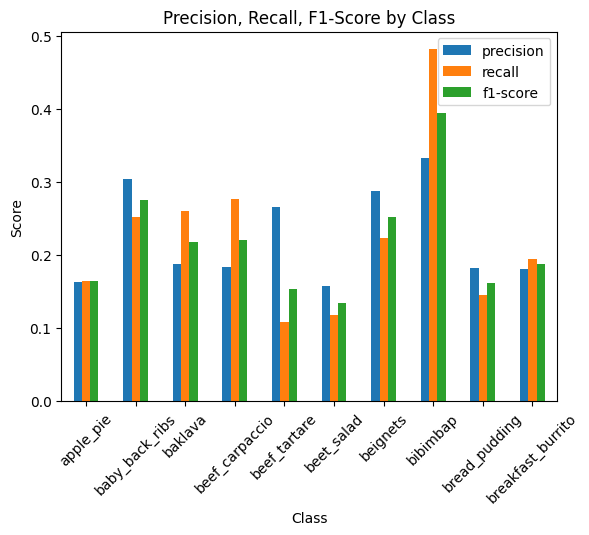

In [17]:
# 3. Plot precision, recall, f1-score
# Convert classification report to DataFrame for visualization
report_dict = classification_report(y_val, y_val_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).T
report_df = report_df.iloc[:-3]  # Remove support and avg rows if present

plt.figure(figsize=(10, 6))
metrics_df = report_df[['precision', 'recall', 'f1-score']]
metrics_df.plot(kind='bar')
plt.title('Precision, Recall, F1-Score by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

# Visualize metrics: Plot runtime performance

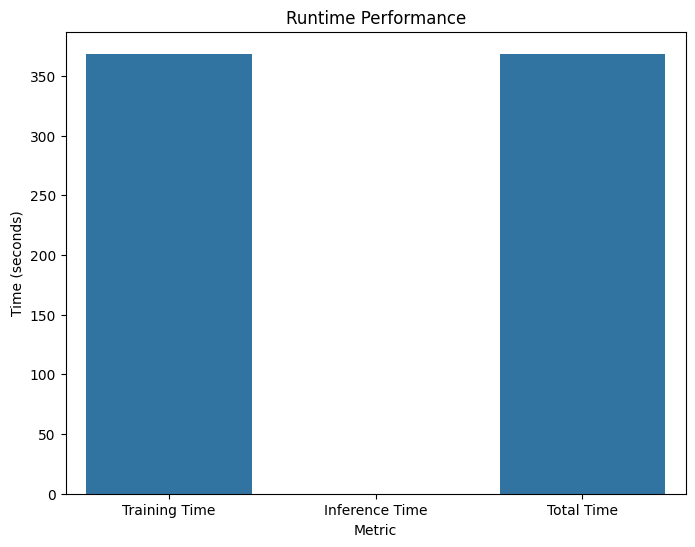

In [18]:
# 4. Plot runtime performance
# Here we show the runtime performance for training and inference
# Note: For demonstration, we use the grid search training time and a quick inference time measurement

inference_start = time.time()
_ = best_dt.predict(X_val_final)
inference_time = time.time() - inference_start

performance = pd.DataFrame({
    'Metric': ['Training Time', 'Inference Time', 'Total Time'],
    'Time (seconds)': [train_time, inference_time, train_time + inference_time]
})
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Time (seconds)', data=performance)
plt.title('Runtime Performance')
plt.ylabel('Time (seconds)')
plt.show()

# Visualize metrics: Depth vs. Accuracy plot (to tune the model)

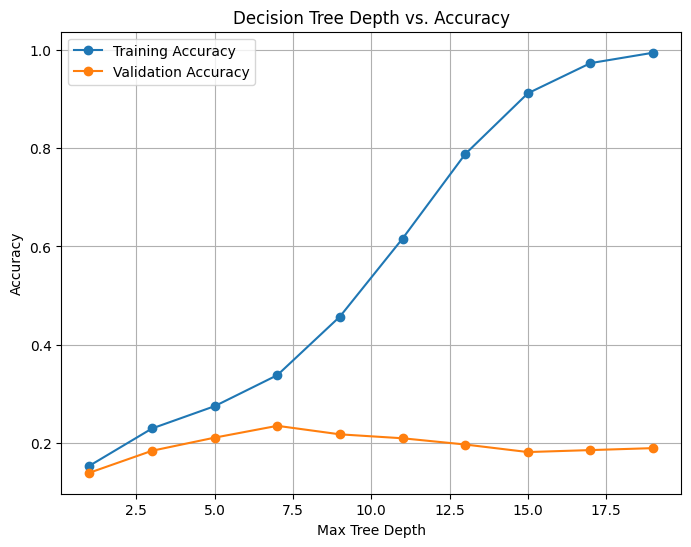

In [19]:
# 5. Depth vs. Accuracy plot (to tune the model)
# This shows how accuracy changes with tree depth
max_depths = [d for d in range(1, 21, 2)]
train_scores = []
val_scores = []

for depth in max_depths:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_temp.fit(X_train_final, y_train)
    train_scores.append(accuracy_score(y_train, dt_temp.predict(X_train_final)))
    val_scores.append(accuracy_score(y_val, dt_temp.predict(X_val_final)))

plt.figure(figsize=(8, 6))
plt.plot(max_depths, train_scores, 'o-', label='Training Accuracy')
plt.plot(max_depths, val_scores, 'o-', label='Validation Accuracy')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Depth vs. Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Runtime Performance Summary

In [20]:
# Runtime performance summary
runtime_summary = {
    'Total Images': len(y_train) + len(y_val),
    'Training Time (s)': train_time,
    'Inference Time (s)': inference_time,
    'Images per Second (Training)': len(y_train) / train_time,
    'Images per Second (Inference)': len(y_val) / inference_time
}

print("\nRuntime Performance Summary:")
for key, value in runtime_summary.items():
    print(f"{key}: {value}")


Runtime Performance Summary:
Total Images: 7500
Training Time (s): 368.6464755535126
Inference Time (s): 0.0011034011840820312
Images per Second (Training): 16.275755765713384
Images per Second (Inference): 1359433.0164217805
